# Finetuning

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re
import torch
import tqdm
from pandas.api.types import CategoricalDtype

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Connect to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%ls

In [ ]:
%cd drive/MyDrive/reflection-classification/

In [ ]:
%ls

## Import dataset

In [2]:
# import sentences
sentences_en_tr = pd.read_csv('../input/cered-dataset/data/sentences/en/train/sentences.tsv',sep='\t')
sentences_en_val = pd.read_csv('../input/cered-dataset/data/sentences/en/val/sentences.tsv',sep='\t')
sentences_en_te = pd.read_csv('../input/cered-dataset/data/sentences/en/test/sentences.tsv',sep='\t')
print(f'In English\nLenght training set : {len(sentences_en_tr)}')
print(f'Lenght validation set : {len(sentences_en_val)}')
print(f'Lenght testing set : {len(sentences_en_te)}')

sentences_en_te.head()

In English
Lenght training set : 6096
Lenght validation set : 339
Lenght testing set : 339


,idx,context,sentence,y,confidence,y_requires_context
0,1139,"Some struggled with it a bit, but even that is...",A few days ago I taught a class of seventh gra...,Experience,"[6, 3]",NaN
1,3566,The student with LMR had an assistant in the c...,had a very good feeling about some of the chil...,Feeling,"[5, 5]",NaN
2,6104,C prepared that it was perhaps the worst class...,"They had a teacher from civics who, among othe...",Other,"[6, 7]",NaN
3,8,"But I came and ruined everything. In addition,...","Of the lessons learned, this one was the most ...",Difficulties,"[4, 5]",K
4,2290,The teacher told me that she is happy about it...,"I have a good feeling about the teacher, you c...",Feeling,"[5, 4]",NaN


In [3]:
# turn internet on on kaggle before running this cell
!pip install transformers[torch]
#!pip install accelerate -U  # restart runtime if it still doesn't work
!pip install datasets
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 858.5 kB/s eta 0:00:00a 0:00:01


 ## Finetuning on CERED dataset with custom training loop

 with small BERT

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
import numpy as np
import pandas as pd
import torch
import evaluate
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, TrainingArguments
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from datasets import load_metric

In [34]:
# functions :
#   - preprocess_data
#   - prepare_model
#   - train
#   - evalaute

def preprocess_data(df_sentences_train, df_sentences_test):
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    #data['text'] = df_sentences['sentence']
    #data['label'] = df_sentences['y']

    # Preprocess data and labels
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

    max_length_train = max(df_sentences_train['sentence'].apply(lambda sentence: len(sentence.split())))
    max_length_test = max(df_sentences_test['sentence'].apply(lambda sentence: len(sentence.split())))

    df_train['text'] = df_sentences_train['sentence'].apply(
        lambda x: tokenizer.encode(x, add_special_tokens=True, padding='max_length', truncation = True, max_length=max_length_train))
    df_test['text'] = df_sentences_test['sentence'].apply(
        lambda x: tokenizer.encode(x, add_special_tokens=True, padding='max_length', truncation = True, max_length=max_length_test))
    
    label_encoder_train = LabelEncoder()
    label_encoder_test = LabelEncoder()
    df_test['label'] = label_encoder_train.fit_transform(df_sentences_test['y'])
    df_train['label'] = label_encoder_test.fit_transform(df_sentences_train['y']) # in output for evaluation
    
    # Split the data into training and validation sets
    train_data, val_data = train_test_split(df_train, test_size=0.1, random_state=42)
    test_data = df_test
    print(f"Train data : {len(train_data)}")
    print(f"Val data : {len(val_data)}")
    print(f"Test data : {len(test_data)}")
    
    # Create a custom dataset
    class CustomDataset(Dataset):
        def __init__(self, text, label):
            self.text = text
            self.label = label
        def __len__(self):
            return len(self.text)
        def __getitem__(self, idx):
            return {
              'text': torch.tensor(self.text[idx], dtype=torch.long),
              'label': torch.tensor(self.label[idx], dtype=torch.long)
          }
    train_dataset = CustomDataset(train_data['text'].values, train_data['label'].values)
    val_dataset = CustomDataset(val_data['text'].values, val_data['label'].values)
    test_dataset = CustomDataset(test_data['text'].values, test_data['label'].values)

    return train_dataset, val_dataset, test_dataset, label_encoder_test

def prepare_model(model, train_dataset, val_dataset, test_dataset, freeze_weights, batch_size, epochs, learning_rate):

    if freeze_weights:
        # Freeze all layers except the last two
        for param in model.parameters():
            param.requires_grad = False
        for param in model.classifier.parameters():
            param.requires_grad = True

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Set up optimizer and scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * epochs)

    return train_loader, val_loader, test_loader, optimizer, scheduler

def train(model, train_loader, epochs, optimizer, scheduler, device, plot_visualization):
    accuracy_metric = load_metric("accuracy")
    train_losses = []
    avg_acc_per_epoch = []

    for epoch in range(epochs):
        print(f"epoch {epoch} running...")
        model.train()
        train_loss = []
        acc = []
        all_preds = []
        all_labels = []

        for batch in train_loader:
            optimizer.zero_grad()
            inputs = batch['text'].to(device)
            labels = batch['label'].to(device)
            outputs = model(inputs, labels=labels)
            loss = outputs.loss
            train_loss.append(loss.item())
            loss.backward()
            optimizer.step()
            scheduler.step()
            ### to plot accuracy during training ###
            predictions = torch.argmax(outputs.logits, axis=1)
            all_preds.extend(predictions.cpu().numpy().tolist())
            all_labels.extend(labels.tolist())
            ########################################
        avg_epoch_loss = sum(train_loss) / len(train_loss)
        train_losses.append(avg_epoch_loss)
        avg_acc_per_epoch.append(accuracy_metric.compute(predictions=all_preds, references=all_labels)["accuracy"])
    
    if plot_visualization == True:
        fig, axs = plt.subplots(1,2, figsize = (12,5))
        axs[0].plot(range(epochs), train_losses, label='Training Loss')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Loss')
        axs[0].set_title('Training Loss over Epochs')
        axs[0].set_xticks(np.arange(epochs))
        axs[0].legend()

        axs[1].plot(range(epochs), avg_acc_per_epoch, label='Training Accuracy')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Accuracy')
        axs[1].set_title('Training Accuracy over Epochs')
        axs[1].set_xticks(np.arange(epochs))
        axs[1].legend()
        plt.show()
    
    return train_losses, avg_acc_per_epoch

def evaluate(model, test_loader, label_encoder, device, plot_results, accuracy_metric):
    model.eval()
    all_preds = []
    all_labels = []
    pred_confidence = []
    train_confidence_scores = []
    with torch.no_grad():
        for batch in test_loader:
            inputs = batch['text'].to(device)
            labels = batch['label'].to(device)
            outputs = model(inputs)
            predictions = torch.argmax(outputs.logits, axis=1)
            all_preds.extend(predictions.cpu().numpy().tolist())
            all_labels.extend(labels.tolist())
            ### compute confidence score
            probabilities = torch.softmax(outputs.logits, dim=1)
            pred_confidence.extend(probabilities.max(dim=1).values.cpu().detach().numpy())  # Confidence scores
            ###
        #train_confidence_scores.append(np.mean(train_confidence))  # Store confidence scores

    # compute accuracy
    accuracy = accuracy_metric.compute(predictions=all_preds, references=all_labels)["accuracy"]
    print(f"Accuracy: {np.round(accuracy,3)}")
    # Decode label encodings
    predicted_labels = label_encoder.inverse_transform(all_preds)
    true_labels = label_encoder.inverse_transform(all_labels)

    # Get unique labels from true and predicted labels and their union for the confusion matrix
    unique_true_labels = set(predicted_labels)
    unique_predicted_labels = set(true_labels)
    unique_labels_union = unique_true_labels.union(unique_predicted_labels)

    # Sort the labels alphabetically to ensure consistent order
    class_labels = sorted(unique_labels_union)
    print(f"Missing labels : {set(['Belief', 'Difficulty', 'Experience', 'Feeling', 'Other', 'Reflection', 'Learning', 'Perspective', 'Intention']) - unique_labels_union}\n")
    
    if plot_results:
        # Generate classification report
        report = classification_report(true_labels, predicted_labels, zero_division = 1, target_names=class_labels)
        print(report)

        # Create confusion matrix
        cm = confusion_matrix(true_labels, predicted_labels, labels=class_labels)

        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
        # Subplot 1: Confusion Matrix
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels, ax=axs[0])
        axs[0].set_xlabel("Predicted")
        axs[0].set_ylabel("True")
        axs[0].set_title("Confusion Matrix")

        # Subplot 2: Confidence Scores Histogram
        axs[1].hist(pred_confidence, bins=50)
        axs[1].set_xlabel('Confidence score')
        axs[1].set_ylabel('Number of predictions')
        axs[1].set_title('Confidence score of predictions')

        plt.tight_layout()
        plt.show()

In [ ]:
# Load data from data.csv 
df_sentences_train = pd.read_csv('../input/cered-dataset/data/sentences/en/train/sentences.tsv',sep='\t')
df_sentences_test = pd.read_csv('../input/cered-dataset/data/sentences/en/test/sentences.tsv',sep='\t')

train_dataset, val_dataset, test_dataset, label_encoder_test = preprocess_data(df_sentences_train, df_sentences_test)

# Initialize the pre-trained BERT model
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=9).to(device)

# Define training parameters
batch_size, epochs, learning_rate = 5, 8, 2e-5
freeze_weights = False

train_loader, val_loader, test_loader, optimizer, scheduler = prepare_model(model, train_dataset, val_dataset, test_dataset, freeze_weights, batch_size, epochs, learning_rate)

In [ ]:
# train model
train_loss, train_acc = train(model = model,
      train_loader = train_loader,
      epochs = epochs,
      optimizer = optimizer,
      scheduler = scheduler,
      device = device,
      plot_visualization = True)

In [ ]:
# evaluate model
evaluate(model = model,
         test_loader = test_loader,
         label_encoder = label_encoder_test,
         device = device,
         plot_classification_report = True,
         plot_confusion_matrix = True,
         plot_confidence_score = True,
         accuracy_metric = load_metric("accuracy"))

## With train/val/test splits

In [7]:
def train_test(model, train_loader, val_loader, epochs, optimizer, scheduler, device):
    accuracy_metric = load_metric("accuracy")
    train_losses = []
    val_losses = []
    avg_train_acc_per_epoch = []
    avg_val_acc_per_epoch = []
    train_confidence_scores = []  # Store confidence scores for train set
    val_confidence_scores = []    # Store confidence scores for validation set

    for epoch in range(epochs):
        print(f"epoch {epoch} running...")
        model.train()
        train_loss = []
        all_preds_train = []
        all_labels_train = []
        train_confidence = []

        for batch in train_loader:
            optimizer.zero_grad()
            inputs = batch['text'].to(device)
            labels = batch['label'].to(device)
            outputs = model(inputs, labels=labels)
            loss = outputs.loss
            train_loss.append(loss.item())
            predictions_train = torch.argmax(outputs.logits, axis=1)
            all_preds_train.extend(predictions_train.cpu().numpy().tolist())
            all_labels_train.extend(labels.tolist())
            ### compute confidence score
            probabilities = torch.softmax(outputs.logits, dim=1)
            train_confidence.extend(probabilities.max(dim=1).values.cpu().detach().numpy())  # Confidence scores
            ###
            loss.backward()
            optimizer.step()
            scheduler.step()

        avg_epoch_loss_train = sum(train_loss) / len(train_loss)
        train_losses.append(avg_epoch_loss_train)
        avg_train_acc_per_epoch.append(accuracy_metric.compute(predictions=all_preds_train, references=all_labels_train)["accuracy"])
        train_confidence_scores.append(np.mean(train_confidence))  # Store confidence scores
        
        # Validation loop
        model.eval()
        val_loss = []
        all_preds_val = []
        all_labels_val = []
        val_confidence = []

        with torch.no_grad():
            for batch in val_loader:
                inputs = batch['text'].to(device)
                labels = batch['label'].to(device)
                outputs = model(inputs, labels=labels)
                loss_val = outputs.loss
                val_loss.append(loss_val.item())
                predictions_val = torch.argmax(outputs.logits, axis=1)
                all_preds_val.extend(predictions_val.cpu().numpy().tolist())
                all_labels_val.extend(labels.tolist())
                probabilities = torch.softmax(outputs.logits, dim=1)
                val_confidence.extend(probabilities.max(dim=1).values.cpu().detach().numpy())  # Confidence scores

        avg_epoch_loss_val = sum(val_loss) / len(val_loss)
        val_losses.append(avg_epoch_loss_val)
        avg_val_acc_per_epoch.append(accuracy_metric.compute(predictions=all_preds_val, references=all_labels_val)["accuracy"])
        val_confidence_scores.append(np.mean(val_confidence))  # Store confidence scores

    return train_losses, val_losses, avg_train_acc_per_epoch, avg_val_acc_per_epoch, train_confidence_scores, val_confidence_scores


In [ ]:
# Load data from data.csv
df_sentences_train = pd.read_csv('../input/cered-dataset/data/sentences/en/train/sentences.tsv',sep='\t')
df_sentences_test = pd.read_csv('../input/cered-dataset/data/sentences/en/test/sentences.tsv',sep='\t')

train_dataset, val_dataset, test_dataset, label_encoder_test = preprocess_data(df_sentences_train, df_sentences_test)

# Initialize the pre-trained BERT model
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=9).to(device)

# Define training parameters
batch_size, epochs, learning_rate = 5, 8, 2e-5
freeze_weights = False

train_loader, val_loader, test_loader, optimizer, scheduler = prepare_model(model, train_dataset, val_dataset, test_dataset, freeze_weights, batch_size, epochs, learning_rate)

In [ ]:
%%time
# Assuming you have your train_loader and val_loader
train_losses, val_losses, avg_train_acc_per_epoch, avg_val_acc_per_epoch, train_confidence_scores, val_confidence_scores  = train_test(
                                                                                                                                model,
                                                                                                                                train_loader,
                                                                                                                                val_loader,
                                                                                                                                epochs=epochs,
                                                                                                                                optimizer=optimizer,
                                                                                                                                scheduler=scheduler,
                                                                                                                                device=device)


In [ ]:
fig, axs = plt.subplots(1,3, figsize = (12,5))
axs[0].plot(range(epochs), train_losses, label='Training Loss')
axs[0].plot(range(epochs), val_losses, label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Train and Val Loss over Epochs')
axs[0].set_xticks(np.arange(epochs))
axs[0].legend()

axs[1].plot(range(epochs), avg_train_acc_per_epoch, label='Training Accuracy')
axs[1].plot(range(epochs), avg_val_acc_per_epoch, label='Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Train and Val Accuracy over Epochs')
axs[1].set_xticks(np.arange(epochs))
axs[1].legend()

print("Confidence score are averaged per batch")
axs[2].plot(range(epochs), train_confidence_scores, label='Tr Confidence score')
axs[2].plot(range(epochs), val_confidence_scores, label='Val Confidence score ')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Confidence score')
axs[2].set_title('Train and Val Confidence score over Epochs')
axs[2].set_xticks(np.arange(epochs))
axs[2].legend()
plt.tight_layout()
plt.show()

In [ ]:
# evaluate model on test dataset
evaluate(model = model,
         test_loader = test_loader,
         label_encoder = label_encoder_test,
         device = device,
         plot_classification_report = True,
         plot_confusion_matrix = True,
         plot_confidence_score = True,
         accuracy_metric = load_metric("accuracy"))

### Finetuning with 5-fold CV

In [18]:
def preprocess_data_for_CV(df_sentences_train, df_sentences_test, train_index, val_index):
    
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    
    # Preprocess data and labels
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

    max_length_train = max(df_sentences_train['sentence'].apply(lambda sentence: len(sentence.split())))
    max_length_test = max(df_sentences_test['sentence'].apply(lambda sentence: len(sentence.split())))

    df_train['text'] = df_sentences_train['sentence'].apply(
        lambda x: tokenizer.encode(x, add_special_tokens=True, padding='max_length', truncation = True, max_length=max_length_train))
    df_test['text'] = df_sentences_test['sentence'].apply(
        lambda x: tokenizer.encode(x, add_special_tokens=True, padding='max_length', truncation = True, max_length=max_length_test))
    
    label_encoder_train = LabelEncoder()
    label_encoder_test = LabelEncoder()
    df_train['label'] = label_encoder_train.fit_transform(df_sentences_train['y']) 
    df_test['label'] = label_encoder_test.fit_transform(df_sentences_test['y']) # in output for evaluation
    
    # Split the data into training and validation sets with CV splits
    train_data = df_train.iloc[train_index]
    val_data = df_train.iloc[val_index]
    
    test_data = df_test
    print(f"Train data : {len(train_data)}")
    print(f"Val data : {len(val_data)}")
    print(f"Test data : {len(test_data)}")

    
    # Create a custom dataset
    class CustomDataset(Dataset):
        def __init__(self, text, label):
            self.text = text
            self.label = label
        def __len__(self):
            return len(self.text)
        def __getitem__(self, idx):
            return {
              'text': torch.tensor(self.text[idx], dtype=torch.long),
              'label': torch.tensor(self.label[idx], dtype=torch.long)
            }
    train_dataset = CustomDataset(train_data['text'].values, train_data['label'].values)
    val_dataset = CustomDataset(val_data['text'].values, val_data['label'].values)
    test_dataset = CustomDataset(test_data['text'].values, test_data['label'].values)

    return train_dataset, val_dataset, test_dataset, label_encoder_test

def cross_validate(df_sentences_train, df_sentences_test, freeze_weights, batch_size, epochs, learning_rate, predictions_list, true_labels_list, n_splits, train_loss_list, train_acc_list, val_loss_list, val_acc_list, device):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    best_val_acc = 0.0
    best_model = None

    for fold, (train_index, val_index) in enumerate(kf.split(df_sentences_train)):
        print(f"Fold {fold + 1}:")

        train_dataset, val_dataset, test_dataset, label_encoder_test = preprocess_data_for_CV(df_sentences_train, df_sentences_test, train_index, val_index)

        # Initialize the pre-trained BERT model
        model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=9).to(device)
        train_loader, val_loader, test_loader, optimizer, scheduler = prepare_model(model, train_dataset, val_dataset, test_dataset, freeze_weights, batch_size, epochs, learning_rate)
        
        train_loss_fold, val_loss_fold, train_acc_fold, val_acc_fold, _, _ = train_test(model, train_loader, val_loader, epochs, optimizer, scheduler, device)
        
        train_loss_list.extend(train_loss_fold)
        train_acc_list.extend(train_acc_fold)
        val_loss_list.extend(val_loss_fold)
        val_acc_list.extend(val_acc_fold) 

        # Evaluate validation accuracy
        val_accuracy = val_acc_fold[-1]  # Assuming val_acc_fold contains accuracy values for each epoch

        # Update best model if current fold's validation accuracy is higher
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_model = model.state_dict()  # Store the state dict of the best model
        
    return train_loss_list, val_loss_list, train_acc_list, val_acc_list, label_encoder_test, test_loader, best_model


### Train CV

In [27]:
%%time
# Load your data from data.csv
df_sentences_train = pd.read_csv('../input/cered-dataset/data/sentences/en/val/sentences.tsv',sep='\t')
df_sentences_test = pd.read_csv('../input/cered-dataset/data/sentences/en/test/sentences.tsv',sep='\t')

# remove category 'Reflexion'
df_sentences_train = df_sentences_train[df_sentences_train['y'] != 'Reflection']
df_sentences_test = df_sentences_test[df_sentences_test['y'] != 'Reflection']

# Set hyperparameters
batch_size = 4
epochs = 10
learning_rate = 2e-5
n_splits = 5

predictions_list = []
true_labels_list = []
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

train_loss_list, val_loss_list, train_acc_list, val_acc_list, label_encoder_test, test_loader, best_model  = cross_validate(df_sentences_train=df_sentences_train,
                                                                                    df_sentences_test=df_sentences_test,
                                                                                    freeze_weights=False, 
                                                                                    batch_size=batch_size, 
                                                                                    epochs=epochs, 
                                                                                    learning_rate=learning_rate,
                                                                                    predictions_list = predictions_list,
                                                                                    true_labels_list = true_labels_list,
                                                                                    n_splits=n_splits,
                                                                                    train_loss_list = train_loss_list,
                                                                                    train_acc_list = train_acc_list,
                                                                                    val_loss_list = val_loss_list,
                                                                                    val_acc_list = val_acc_list,
                                                                                    device = device)

Fold 1:
Train data : 242
Val data : 61
Test data : 299


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0 running...
epoch 1 running...
epoch 2 running...
epoch 3 running...
epoch 4 running...
epoch 5 running...
epoch 6 running...
epoch 7 running...
epoch 8 running...
epoch 9 running...
Fold 2:
Train data : 242
Val data : 61
Test data : 299


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0 running...
epoch 1 running...
epoch 2 running...
epoch 3 running...
epoch 4 running...
epoch 5 running...
epoch 6 running...
epoch 7 running...
epoch 8 running...
epoch 9 running...
Fold 3:
Train data : 242
Val data : 61
Test data : 299


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0 running...
epoch 1 running...
epoch 2 running...
epoch 3 running...
epoch 4 running...
epoch 5 running...
epoch 6 running...
epoch 7 running...
epoch 8 running...
epoch 9 running...
Fold 4:
Train data : 243
Val data : 60
Test data : 299


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0 running...
epoch 1 running...
epoch 2 running...
epoch 3 running...
epoch 4 running...
epoch 5 running...
epoch 6 running...
epoch 7 running...
epoch 8 running...
epoch 9 running...
Fold 5:
Train data : 243
Val data : 60
Test data : 299


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0 running...
epoch 1 running...
epoch 2 running...
epoch 3 running...
epoch 4 running...
epoch 5 running...
epoch 6 running...
epoch 7 running...
epoch 8 running...
epoch 9 running...
CPU times: user 4min 33s, sys: 691 ms, total: 4min 33s
Wall time: 4min 35s


### Print results (loss and accuracy)

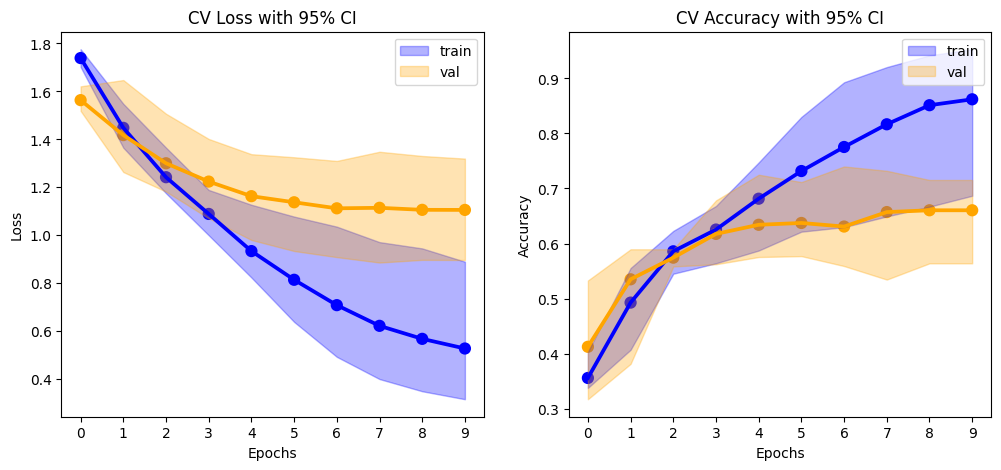

In [28]:
train_loss_array = np.array(train_loss_list).reshape(n_splits,epochs)
mean_train_loss = np.mean(train_loss_array, axis=0)
ci_train_loss = np.percentile(train_loss_array, [2.5, 97.5], axis=0)

val_loss_array = np.array(val_loss_list).reshape(n_splits,epochs)
mean_val_loss = np.mean(val_loss_array, axis=0)
ci_val_loss = np.percentile(val_loss_array, [2.5, 97.5], axis=0)

# Create a DataFrame for Seaborn
df_train_loss = pd.DataFrame({
    'Epochs': np.arange(epochs),
    'Mean Train Loss': mean_train_loss,
    'Lower CI': ci_train_loss[0],
    'Upper CI': ci_train_loss[1]})

df_val_loss = pd.DataFrame({
    'Epochs': np.arange(epochs),
    'Mean Val Loss': mean_val_loss,
    'Lower CI': ci_val_loss[0],
    'Upper CI': ci_val_loss[1]})

# Code for Accuracy Plot (Second Subplot)
train_acc_array = np.array(train_acc_list).reshape(n_splits, epochs)
val_acc_array = np.array(val_acc_list).reshape(n_splits, epochs)
ci_train_acc = np.percentile(train_acc_array, [2.5, 97.5], axis=0)

mean_train_acc = np.mean(train_acc_array, axis=0)
mean_val_acc = np.mean(val_acc_array, axis=0)
ci_val_acc = np.percentile(val_acc_array, [2.5, 97.5], axis=0)

df_train_acc = pd.DataFrame({
    'Epochs': np.arange(epochs), 
    'Mean Train Accuracy': mean_train_acc,
    'Lower CI': ci_train_acc[0],
    'Upper CI': ci_train_acc[1]})

df_val_acc = pd.DataFrame({
    'Epochs': np.arange(epochs),
    'Mean Val Accuracy': mean_val_acc,
    'Lower CI': ci_val_acc[0],
    'Upper CI': ci_val_acc[1]})

#df_train_loss.head()
#df_val_loss.head()

fig, axs = plt.subplots(1,2, figsize=(12,5))
# Plot the mean accuracy line
sns.pointplot(data=df_train_loss, x='Epochs', y='Mean Train Loss', color='blue', ax = axs[0])
sns.pointplot(data=df_val_loss, x='Epochs', y='Mean Val Loss', color='orange', ax = axs[0])

sns.pointplot(data=df_train_acc, x='Epochs', y='Mean Train Accuracy', color='blue', ax = axs[1])
sns.pointplot(data=df_val_acc, x='Epochs', y='Mean Val Accuracy', color='orange', ax = axs[1])

# Fill between the confidence interval
axs[0].fill_between(df_train_loss['Epochs'], df_train_loss['Lower CI'], df_train_loss['Upper CI'], color='blue', alpha=0.3, label = 'train')
axs[0].fill_between(df_val_loss['Epochs'], df_val_loss['Lower CI'], df_val_loss['Upper CI'], color='orange', alpha=0.3, label = 'val')
axs[0].legend()
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_title('CV Loss with 95% CI')

axs[1].fill_between(df_train_acc['Epochs'], df_train_acc['Lower CI'], df_train_acc['Upper CI'], color='blue', alpha=0.3, label = 'train')
axs[1].fill_between(df_val_acc['Epochs'], df_val_acc['Lower CI'], df_val_acc['Upper CI'], color='orange', alpha=0.3, label = 'val')

axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('CV Accuracy with 95% CI')

plt.legend()
plt.show()

### Evaluation of the best model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.622
Missing labels : {'Reflection', 'Difficulty'}

              precision    recall  f1-score   support

      Belief       0.40      0.09      0.15        22
Difficulties       0.30      0.27      0.29        22
  Experience       0.69      0.77      0.73        88
     Feeling       0.54      0.70      0.61        69
   Intention       1.00      0.00      0.00         1
    Learning       1.00      0.00      0.00        13
       Other       0.72      0.77      0.74        81
 Perspective       1.00      0.00      0.00         3

    accuracy                           0.62       299
   macro avg       0.71      0.32      0.31       299
weighted avg       0.63      0.62      0.59       299



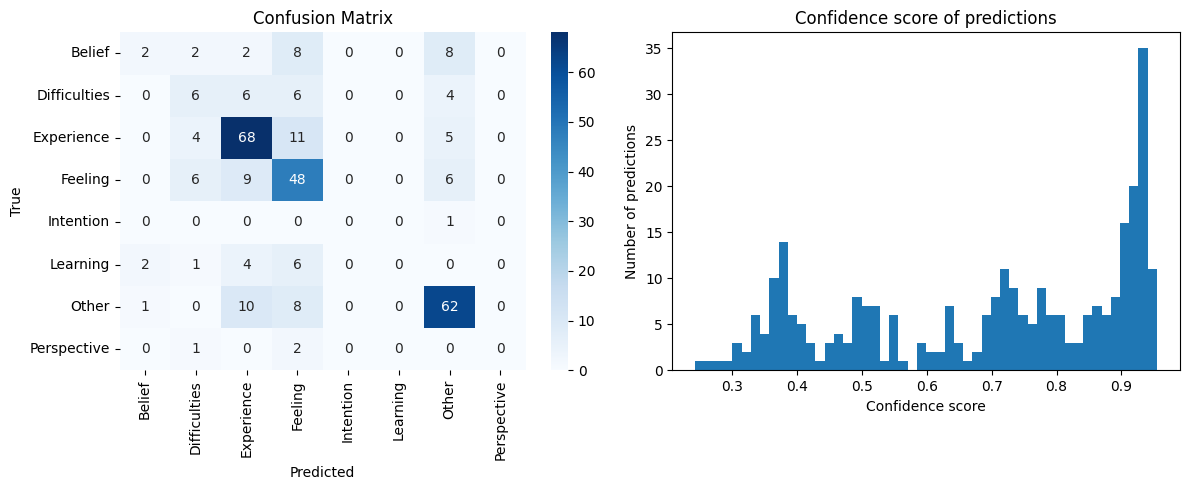

In [35]:
# Initialize the model
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=9).to(device)

# Load the state dictionary of the best model
model.load_state_dict(best_model)

# Evaluate the best model
evaluate(model=model,
             test_loader=test_loader,
             label_encoder=label_encoder_test,
             device=device,
             plot_results = True,
             accuracy_metric = load_metric("accuracy"))

### CV for each class

In [52]:
# Load your data from data.csv
df_sentences_train = pd.read_csv('../input/cered-dataset/data/sentences/en/val/sentences.tsv',sep='\t')
df_sentences_test = pd.read_csv('../input/cered-dataset/data/sentences/en/test/sentences.tsv',sep='\t')

# remove category 'Reflexion'
df_sentences_train = df_sentences_train[df_sentences_train['y'] != 'Reflection']
df_sentences_test = df_sentences_test[df_sentences_test['y'] != 'Reflection']

# Select the reflective categories and show their distribution
reflective_cat_in_order = list(df_sentences_train["y"].value_counts().sort_values(ascending=False).index)
reflective_cat_in_order_wo_other = [item for item in reflective_cat_in_order if item != 'Other']
print(f"List of reflective categories in order : {reflective_cat_in_order}")
print(f"List of reflective categories in order without 'Other': {reflective_cat_in_order_wo_other}")

topN_classes = reflective_cat_in_order_wo_other[:4]
reflective_categories = topN_classes
print(f"topN reflective categories: {reflective_categories}")

List of reflective categories in order : ['Other', 'Experience', 'Feeling', 'Difficulty', 'Belief', 'Perspective', 'Learning', 'Intention']
List of reflective categories in order without 'Other': ['Experience', 'Feeling', 'Difficulty', 'Belief', 'Perspective', 'Learning', 'Intention']
topN reflective categories: ['Experience', 'Feeling', 'Difficulty', 'Belief']


In [53]:
%%time
# Set hyperparameters
batch_size = 4
epochs = 8
learning_rate = 2e-5
n_splits = 3

dfs_train = {}
dfs_val = {}
best_model = {}
predictions_list = []
true_labels_list = []
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

print(f"\n\nLaunching {n_splits}-fold CV per class with : {reflective_categories}")

for i, cat in enumerate(reflective_categories):
    print(f"\n\nCV for {cat}")
    train_loss_list = []
    val_loss_list = []
    df_sentences_bin = df_sentences_train.copy()
    df_sentences_bin['y'] = np.where(df_sentences_bin['y'] == cat, cat, 'Other')
    
    train_loss_list, val_loss_list, train_acc_list, val_acc_list, label_encoder_test, _, best_model[cat] = cross_validate(df_sentences_train=df_sentences_bin,
                                                                                                df_sentences_test = df_sentences_test,
                                                                                                freeze_weights=False, 
                                                                                                batch_size=batch_size, 
                                                                                                epochs=epochs, 
                                                                                                learning_rate=learning_rate,
                                                                                                predictions_list = predictions_list,
                                                                                                true_labels_list = true_labels_list,
                                                                                                n_splits=n_splits,
                                                                                                train_loss_list = train_loss_list,
                                                                                                train_acc_list = train_acc_list,
                                                                                                val_loss_list = val_loss_list,
                                                                                                val_acc_list = val_acc_list,
                                                                                                device = device)

    
    train_loss_array = np.array(train_loss_list).reshape(n_splits,epochs)
    mean_train_loss = np.mean(train_loss_array, axis=0)
    ci_train_loss = np.percentile(train_loss_array, [2.5, 97.5], axis=0)

    val_loss_array = np.array(val_loss_list).reshape(n_splits,epochs)
    mean_val_loss = np.mean(val_loss_array, axis=0)
    ci_val_loss = np.percentile(val_loss_array, [2.5, 97.5], axis=0)

    # Create a DataFrame for Seaborn
    df_train_loss = pd.DataFrame({
        'Epochs': np.arange(epochs),
        'Mean Train Loss': mean_train_loss,
        'Lower CI': ci_train_loss[0],
        'Upper CI': ci_train_loss[1]})

    df_val_loss = pd.DataFrame({
        'Epochs': np.arange(epochs),
        'Mean Val Loss': mean_val_loss,
        'Lower CI': ci_val_loss[0],
        'Upper CI': ci_val_loss[1]})
    
    dfs_train[f'{cat}'] = df_train_loss
    dfs_val[f'{cat}'] = df_val_loss



Launching 3-fold CV per class with : ['Experience', 'Feeling', 'Difficulty', 'Belief']


CV for Experience
Fold 1:
Train data : 202
Val data : 101
Test data : 299


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0 running...
epoch 1 running...
epoch 2 running...
epoch 3 running...
epoch 4 running...
epoch 5 running...
epoch 6 running...
epoch 7 running...
Fold 2:
Train data : 202
Val data : 101
Test data : 299


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0 running...
epoch 1 running...
epoch 2 running...
epoch 3 running...
epoch 4 running...
epoch 5 running...
epoch 6 running...
epoch 7 running...
Fold 3:
Train data : 202
Val data : 101
Test data : 299


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0 running...
epoch 1 running...
epoch 2 running...
epoch 3 running...
epoch 4 running...
epoch 5 running...
epoch 6 running...
epoch 7 running...


CV for Feeling
Fold 1:
Train data : 202
Val data : 101
Test data : 299


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0 running...
epoch 1 running...
epoch 2 running...
epoch 3 running...
epoch 4 running...
epoch 5 running...
epoch 6 running...
epoch 7 running...
Fold 2:
Train data : 202
Val data : 101
Test data : 299


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0 running...
epoch 1 running...
epoch 2 running...
epoch 3 running...
epoch 4 running...
epoch 5 running...
epoch 6 running...
epoch 7 running...
Fold 3:
Train data : 202
Val data : 101
Test data : 299


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0 running...
epoch 1 running...
epoch 2 running...
epoch 3 running...
epoch 4 running...
epoch 5 running...
epoch 6 running...
epoch 7 running...


CV for Difficulty
Fold 1:
Train data : 202
Val data : 101
Test data : 299


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0 running...
epoch 1 running...
epoch 2 running...
epoch 3 running...
epoch 4 running...
epoch 5 running...
epoch 6 running...
epoch 7 running...
Fold 2:
Train data : 202
Val data : 101
Test data : 299


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0 running...
epoch 1 running...
epoch 2 running...
epoch 3 running...
epoch 4 running...
epoch 5 running...
epoch 6 running...
epoch 7 running...
Fold 3:
Train data : 202
Val data : 101
Test data : 299


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0 running...
epoch 1 running...
epoch 2 running...
epoch 3 running...
epoch 4 running...
epoch 5 running...
epoch 6 running...
epoch 7 running...


CV for Belief
Fold 1:
Train data : 202
Val data : 101
Test data : 299


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0 running...
epoch 1 running...
epoch 2 running...
epoch 3 running...
epoch 4 running...
epoch 5 running...
epoch 6 running...
epoch 7 running...
Fold 2:
Train data : 202
Val data : 101
Test data : 299


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0 running...
epoch 1 running...
epoch 2 running...
epoch 3 running...
epoch 4 running...
epoch 5 running...
epoch 6 running...
epoch 7 running...
Fold 3:
Train data : 202
Val data : 101
Test data : 299


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0 running...
epoch 1 running...
epoch 2 running...
epoch 3 running...
epoch 4 running...
epoch 5 running...
epoch 6 running...
epoch 7 running...
CPU times: user 7min 42s, sys: 1.37 s, total: 7min 43s
Wall time: 7min 46s


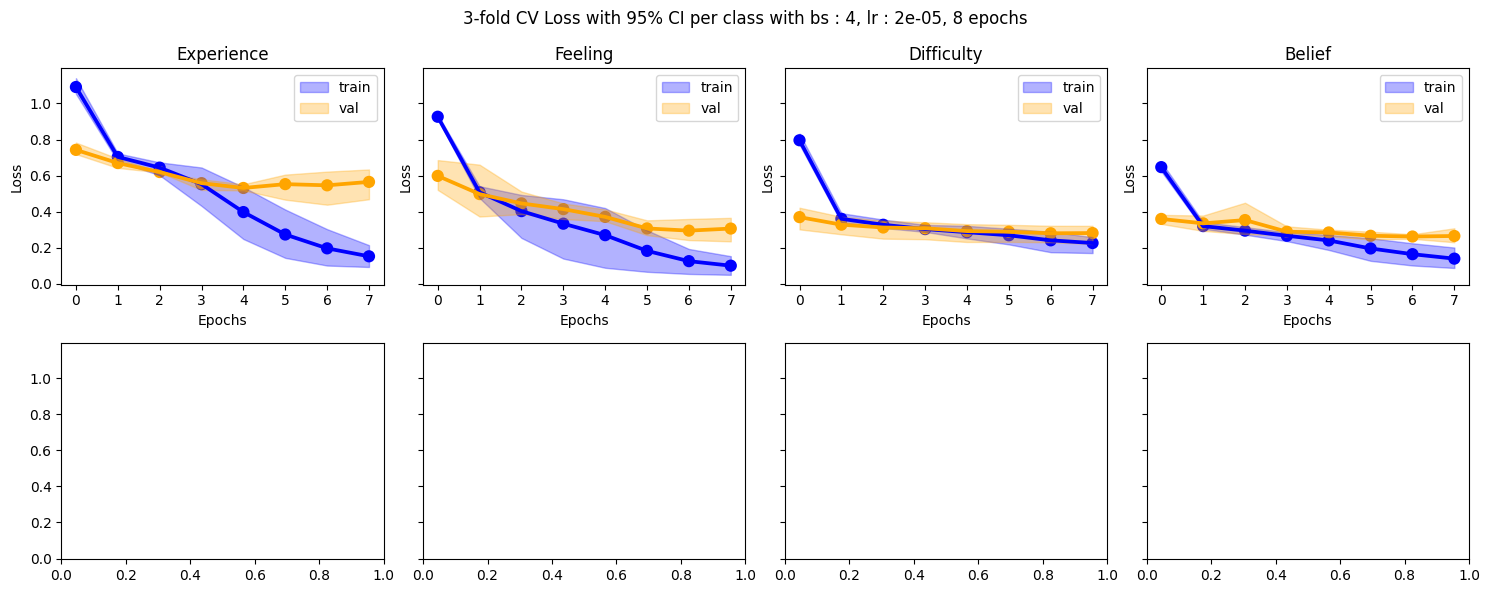

In [54]:
fig, axs = plt.subplots(2, 4, figsize=(15, 6), sharey = True)  

# Sample iteration over the dictionary to plot subplots
for i, cat in enumerate(reflective_categories):
    df_train = dfs_train[cat]
    df_val = dfs_val[cat]
    ax = axs[i // 4, i % 4]
    
    # Mean lineplot
    sns.pointplot(data=df_train, x='Epochs', y='Mean Train Loss', color='blue', ax = ax)
    sns.pointplot(data=df_val, x='Epochs', y='Mean Val Loss', color='orange', ax = ax) 
    
    # Fill between the confidence interval
    ax.fill_between(df_train_loss['Epochs'], df_train['Lower CI'], df_train['Upper CI'], color='blue', alpha=0.3, label = 'train')
    ax.fill_between(df_val_loss['Epochs'], df_val['Lower CI'], df_val['Upper CI'], color='orange', alpha=0.3, label = 'val')
    
    #ax.set_xticks(np.arange(len(training_examples)), training_examples)
    ax.set_xlabel('Epochs')
    ax.set_ylabel("Loss")
    ax.set_title(f"{cat}") 
    ax.legend()

plt.suptitle(f"{n_splits}-fold CV Loss with 95% CI per class with bs : {batch_size}, lr : {learning_rate}, {epochs} epochs")
plt.tight_layout()
plt.show()

### Evaluate for each class

/tmp/ipykernel_32/3013423389.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sentences_test_bin['y'] = np.where(df_sentences_test_bin['y'] == cat, cat, 'Other')


Test data : 299 sentences


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Missing labels : {'Intention', 'Reflection', 'Learning', 'Feeling', 'Perspective', 'Belief', 'Difficulty'}



/tmp/ipykernel_32/3013423389.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sentences_test_bin['y'] = np.where(df_sentences_test_bin['y'] == cat, cat, 'Other')


Test data : 299 sentences


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Missing labels : {'Intention', 'Reflection', 'Belief', 'Learning', 'Perspective', 'Experience', 'Difficulty'}



/tmp/ipykernel_32/3013423389.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sentences_test_bin['y'] = np.where(df_sentences_test_bin['y'] == cat, cat, 'Other')


Test data : 299 sentences


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: y contains previously unseen labels: [1]

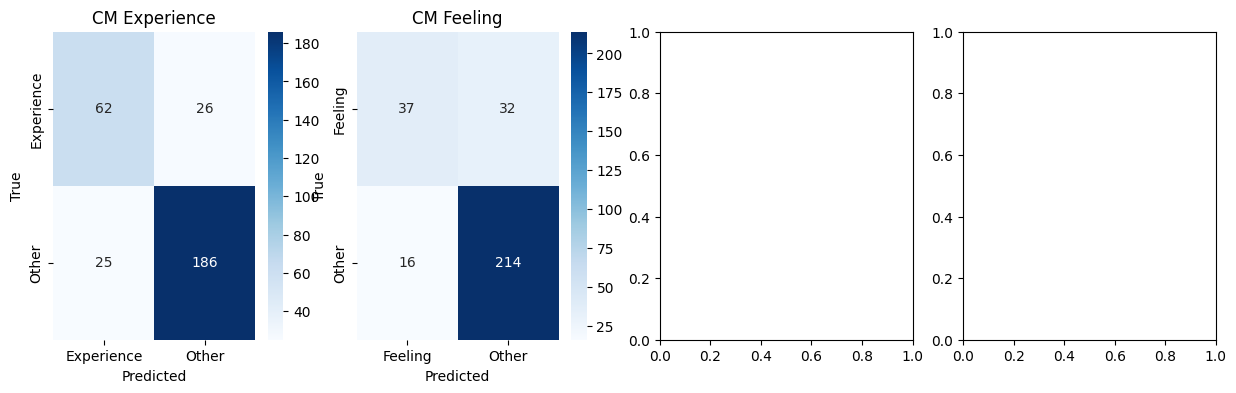

In [73]:
def prepare_test_dataset_for_binclf(df_sentences_test):

    df_test = pd.DataFrame()
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    max_length_test = max(df_sentences_test['sentence'].apply(lambda sentence: len(sentence.split())))
    df_test['text'] = df_sentences_test['sentence'].apply(
            lambda x: tokenizer.encode(x, add_special_tokens=True, padding='max_length', truncation = True, max_length=max_length_test))

    label_encoder_test = LabelEncoder()
    df_test['label'] = label_encoder_test.fit_transform(df_sentences_test['y'])
    print(f"Test data : {len(df_test)} sentences")

    # Create a custom dataset
    class CustomDataset(Dataset):
        def __init__(self, text, label):
            self.text = text
            self.label = label
        def __len__(self):
            return len(self.text)
        def __getitem__(self, idx):
            return {
                'text': torch.tensor(self.text[idx], dtype=torch.long),
                'label': torch.tensor(self.label[idx], dtype=torch.long)
            }

    test_dataset = CustomDataset(df_test['text'].values, df_test['label'].values)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return test_loader, label_encoder_test

#if freeze_weights:
#    # Freeze all layers except the last two
#    for param in model.parameters():
#        param.requires_grad = False
#    for param in model.classifier.parameters():
#        param.requires_grad = True

#####################################
def evaluate_bin(idx, cat, model, test_loader, label_encoder, device, plot_cm, plot_cf, accuracy_metric, axs):
    model.eval()
    all_preds = []
    all_labels = []
    pred_confidence = []
    train_confidence_scores = []
    with torch.no_grad():
        for batch in test_loader:
            inputs = batch['text'].to(device)
            labels = batch['label'].to(device)
            outputs = model(inputs)
            predictions = torch.argmax(outputs.logits, axis=1)
            all_preds.extend(predictions.cpu().numpy().tolist())
            all_labels.extend(labels.tolist())
            ### compute confidence score
            probabilities = torch.softmax(outputs.logits, dim=1)
            pred_confidence.extend(probabilities.max(dim=1).values.cpu().detach().numpy())  # Confidence scores
            ###
        #train_confidence_scores.append(np.mean(train_confidence))  # Store confidence scores

    # compute accuracy
    accuracy = accuracy_metric.compute(predictions=all_preds, references=all_labels)["accuracy"]
    #print(f"Accuracy: {np.round(accuracy,3)}")
    # Decode label encodings
    predicted_labels = label_encoder.inverse_transform(all_preds)
    true_labels = label_encoder.inverse_transform(all_labels)

    # Get unique labels from true and predicted labels and their union for the confusion matrix
    unique_true_labels = set(predicted_labels)
    unique_predicted_labels = set(true_labels)
    unique_labels_union = unique_true_labels.union(unique_predicted_labels)

    # Sort the labels alphabetically to ensure consistent order
    class_labels = sorted(unique_labels_union)
    print(f"Missing labels : {set(['Belief', 'Difficulty', 'Experience', 'Feeling', 'Other', 'Reflection', 'Learning', 'Perspective', 'Intention']) - unique_labels_union}\n")
    
    if plot_cm:
        # Create confusion matrix
        cm = confusion_matrix(true_labels, predicted_labels, labels=class_labels)

        # Confusion Matrix
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels, ax=axs[idx])
        axs[idx].set_xlabel("Predicted")
        axs[idx].set_ylabel("True")
        axs[idx].set_title(f"CM {cat}")
    
    if plot_cf:
        # Confidence Scores Histogram
        axs[idx].hist(pred_confidence, bins=50)
        axs[idx].set_xlabel('Confidence score')
        axs[idx].set_ylabel('Number of predictions')
        axs[idx].set_title(f"Conf. score {cat}")
        
        return accuracy

# Load test dataset
df_sentences_test = pd.read_csv('../input/cered-dataset/data/sentences/en/test/sentences.tsv',sep='\t')
fig, axs = plt.subplots(1, len(reflective_categories), figsize=(15, 4))
accuracies_bin = {}

for i, cat in enumerate(reflective_categories):
    # preprocess the test dataset for each case : each model has been trained for a binary clf
    df_sentences_test_bin = df_sentences_test[df_sentences_test['y'] != 'Reflection']
    df_sentences_test_bin['y'] = np.where(df_sentences_test_bin['y'] == cat, cat, 'Other')
    
    test_loader, label_encoder_test = prepare_test_dataset_for_binclf(df_sentences_test_bin) 
    
    # Initialize the model
    model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=9).to(device)

    # Load the state dictionary of the best model
    model.load_state_dict(best_model[cat])

    # Evaluate the best model
    acc = evaluate_bin(idx = i,
                       cat = cat,
                         model = model,
                         test_loader = test_loader,
                         label_encoder = label_encoder_test,
                         device = device,
                         plot_cm = True,
                         plot_cf = False,
                         accuracy_metric = load_metric("accuracy"),
                         axs = axs)
    accuracies_bin[cat] = acc
print(accuracies_bin[:])
plt.tight_layout()
plt.show()

# Pipeline self-learning for each category
- CV with downsampling (25 / 75 ) and equal distribution of other classes  --> prepare dataset for each class
- plot learning curves for each class with good number of epochs and the corresponding dataset

## Downsampling
- Create balanced datasets with downsampling

In [ ]:
# Load your data from data.csv [train/val/test]
df_sentences = pd.read_csv('../input/cered-dataset/data/sentences/en/train/sentences.tsv',sep='\t')
print(f"Total number of sentences : {len(df_sentences)}")

# Select the reflective categories and show their distribution
reflective_cat_in_order = list(df_sentences["y"].value_counts().sort_values(ascending=False).index)
#reflective_cat_in_order_wo_other = [item for item in reflective_cat_in_order if item != 'Other']
top6_classes = reflective_cat_in_order[:6]
print(f"\nList of reflective categories in order : {reflective_cat_in_order}")
print(f"List of top 6 reflective categories in order: {top6_classes}")

print(df_sentences["y"].value_counts().sort_values(ascending=False))

sns.histplot(df_sentences['y'])
plt.xticks(rotation = 45)
plt.show()

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# 1st option for downsampling
df_sentences_top6_classes = df_sentences[df_sentences['y'].isin(top6_classes)]
print(f"Number of sentences with only top 6 classes : {len(df_sentences_top6_classes)}")

# Separate data by class
df_sentences_per_class_ = {}
balanced_datasets = {}
frac_subsamples = {}

for label in top6_classes:
    df_sentences_per_class[label] = df_sentences[df_sentences['y'] == label]

    # Split the data into minority class and majority class 
    majority_class = df_sentences_top6_classes[df_sentences_top6_classes['y'] != label]
    # Balance the majority class
    under_sampler = RandomUnderSampler(random_state=42)
    majority_balanced, _ = under_sampler.fit_resample(majority_class, majority_class['y'])
    
    minority_class = df_sentences_per_class[label]
    # subsamples at 25% of the dataframe with only wanted label if enough data, else all the data
    n_subsamples = int(0.333*len(majority_balanced)) if (len(minority_class) > 0.25*len(majority_balanced)) else len(minority_class)
    minority_class_subsampled = minority_class.sample(n = n_subsamples, random_state=42) 

    # Combine minority and balanced majority classes
    balanced_datasets[label] = pd.concat([minority_class_subsampled, majority_balanced])
    frac_subsamples[label] = n_subsamples/len(balanced_datasets[label])

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# second option for downsampling
df_sentences_top6_classes = df_sentences[df_sentences['y'].isin(top6_classes)]
print(f"Number of sentences with only top 6 classes : {len(df_sentences_top6_classes)}")

# Separate data by class
df_sentences_per_class = {}
balanced_datasets = {}
frac_subsamples = {}

for label in top6_classes:
    other_labels = [class_ for class_ in top6_classes if class_ != label]
    df_sentences_per_class[label] = df_sentences[df_sentences['y'] == label]
    # 568 = 25% of 2272 = 5*341 (smallest class) + 568
    n_samples_mc = 568 if len(df_sentences_per_class[label]) >= 568 else len(df_sentences_per_class[label])
    under_sampler = RandomUnderSampler(sampling_strategy={label: n_samples_mc, other_labels[0]: 341, other_labels[1]: 341,other_labels[2]: 341,other_labels[3]: 341,other_labels[4]: 341,}, random_state=42)
    balanced_datasets[label], _ = under_sampler.fit_resample(df_sentences_top6_classes, df_sentences_top6_classes['y'])
    frac_subsamples[label] = n_samples_mc/len(balanced_datasets[label])

In [ ]:
fig, axs = plt.subplots(1,6, figsize = (15,4), sharey = True)
for i, label in enumerate(top6_classes):
    #ax = axs[i//3, i%3]
    ax = axs[i]
    sns.histplot(balanced_datasets[label]['y'], ax = ax)
    ax.set_title(f"Dataset {label}, {np.round(frac_subsamples[label],3)}")
    ax.tick_params(axis='x',labelrotation = 45)
plt.tight_layout()
plt.show()

In [ ]:
print(balanced_datasets['Experience']['y'].unique())
balanced_datasets['Experience'].head()

In [ ]:
data_df = {}
reflect_cat = 'Feeling'
for i, nb_train_ex in enumerate([100, 200, 300, 400, 500, 600]):
    data = balanced_datasets[reflect_cat]
    #data['label'] = np.where(df_sentences['y'] == reflective_category, reflective_category, 'Other')

    # Filter data with 'reflective_category' label and take only nb_train_ex samples
    reflective_data = data[data['y'] == reflect_cat].head(nb_train_ex)

    # Filter other data and take remaining samples
    other_data = data[data['y'] != reflect_cat]

    # Concatenate the filtered data
    data = pd.concat([reflective_data, other_data])
    data_df[i] = data
    
fig, axs = plt.subplots(1,6, figsize = (15,4), sharey = True)
for i, label in enumerate([100, 200, 300, 400, 500,600]):
    #ax = axs[i//3, i%3]
    ax = axs[i]
    sns.histplot(data_df[i]['y'], ax = ax)
    ax.set_title(f"train ex. : {label}")
    ax.tick_params(axis='x',labelrotation = 45)
plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(1,6, figsize = (15,4), sharey = True)
for i, label in enumerate([100, 200, 300, 400, 500,600]):
    #ax = axs[i//3, i%3]
    ax = axs[i]
    data_df[i]['y'] = np.where(data_df[i]['y'] == reflect_cat, reflect_cat, 'Other')
    sns.histplot(data_df[i]['y'], ax = ax)
    ax.set_title(f"train ex. : {label}, {np.round(len(data_df[i][data_df[i]['y'] == reflect_cat])/len(data_df[i]),3)}")
    ax.tick_params(axis='x',labelrotation = 45)
plt.tight_layout()
plt.show()

- train the balanced datasets after downsampling

In [ ]:
%%time
# Set hyperparameters
batch_size = 5
epochs = 7
learning_rate = 2e-5
n_splits = 3

dfs_train = {}
dfs_val = {}
predictions_list = []
true_labels_list = []
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

reflective_categories_top3 = ['Experience', 'Feeling', 'Reflection']

print(f"\n\nLaunching {n_splits}-fold CV per class with : {reflective_categories_top3}")

for i, cat in enumerate(reflective_categories_top3):
    print(f"\n\nCV for {cat}")
    train_loss_list = []
    val_loss_list = []
    # Prepare balanced dataset for binary classification
    print(f"Number of sentences in balanced dataset: {len(balanced_datasets[cat])}")
    df_sentences_bin = balanced_datasets[cat]
    df_sentences_bin['y'] = np.where(df_sentences_bin['y'] == cat, cat, 'Other')
    
    train_loss_list, val_loss_list, train_acc_list, val_acc_list = cross_validate(df_sentences=df_sentences_bin,
                                                                            freeze_weights=False, 
                                                                            batch_size=batch_size, 
                                                                            epochs=epochs, 
                                                                            learning_rate=learning_rate,
                                                                            predictions_list = predictions_list,
                                                                            true_labels_list = true_labels_list,
                                                                            n_splits=n_splits,
                                                                            train_loss_list = train_loss_list,
                                                                            train_acc_list = train_acc_list,
                                                                            val_loss_list = val_loss_list,
                                                                            val_acc_list = val_acc_list)

    
    train_loss_array = np.array(train_loss_list).reshape(n_splits,epochs)
    mean_train_loss = np.mean(train_loss_array, axis=0)
    ci_train_loss = np.percentile(train_loss_array, [2.5, 97.5], axis=0)

    val_loss_array = np.array(val_loss_list).reshape(n_splits,epochs)
    mean_val_loss = np.mean(val_loss_array, axis=0)
    ci_val_loss = np.percentile(val_loss_array, [2.5, 97.5], axis=0)

    # Create a DataFrame for Seaborn
    df_train_loss = pd.DataFrame({
        'Epochs': np.arange(epochs),
        'Mean Train Loss': mean_train_loss,
        'Lower CI': ci_train_loss[0],
        'Upper CI': ci_train_loss[1]})

    df_val_loss = pd.DataFrame({
        'Epochs': np.arange(epochs),
        'Mean Val Loss': mean_val_loss,
        'Lower CI': ci_val_loss[0],
        'Upper CI': ci_val_loss[1]})
    
    dfs_train[f'{cat}'] = df_train_loss
    dfs_val[f'{cat}'] = df_val_loss

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6), sharey = True)  

# Sample iteration over the dictionary to plot subplots
for i, cat in enumerate(reflective_categories_top3):
    df_train = dfs_train[cat]
    df_val = dfs_val[cat]
    ax = axs[i] #axs[i // 4, i % 4]
    
    # Mean lineplot
    sns.pointplot(data=df_train, x='Epochs', y='Mean Train Loss', color='blue', ax = ax)
    sns.pointplot(data=df_val, x='Epochs', y='Mean Val Loss', color='orange', ax = ax) 
    
    # Fill between the confidence interval
    ax.fill_between(df_train_loss['Epochs'], df_train['Lower CI'], df_train['Upper CI'], color='blue', alpha=0.3, label = 'train')
    ax.fill_between(df_val_loss['Epochs'], df_val['Lower CI'], df_val['Upper CI'], color='orange', alpha=0.3, label = 'val')
    
    #ax.set_xticks(np.arange(len(training_examples)), training_examples)
    ax.set_xlabel('Epochs')
    ax.set_ylabel("Loss")
    ax.set_title(f"{cat}")
    ax.legend()

plt.suptitle(f"{n_splits}-fold CV Loss with 95% CI per class with bs : {batch_size}, lr : {learning_rate}, {epochs} epochs")
plt.tight_layout()
plt.show()

- Plot the learning curves

In [46]:
# Load your data from data.csv [train/val/test]
df_sentences = pd.read_csv('../input/cered-dataset/data/sentences/en/val/sentences.tsv',sep='\t')

# Select the reflective categories and show their distribution
reflective_cat_in_order = list(df_sentences["y"].value_counts().sort_values(ascending=False).index)
reflective_cat_in_order_wo_other = [item for item in reflective_cat_in_order if item != 'Other']
print(f"List of reflective categories in order : {reflective_cat_in_order}")
print(f"List of reflective categories in order without 'Other': {reflective_cat_in_order_wo_other}")

reflective_categories = reflective_cat_in_order_wo_other
top3_classes = reflective_cat_in_order_wo_other[:3]
reflective_categories = top3_classes

List of reflective categories in order : ['Other', 'Experience', 'Feeling', 'Reflection', 'Difficulty', 'Belief', 'Perspective', 'Learning', 'Intention']
List of reflective categories in order without 'Other': ['Experience', 'Feeling', 'Reflection', 'Difficulty', 'Belief', 'Perspective', 'Learning', 'Intention']


In [ ]:
%%time

# Set hyperparameters
batch_size = 5
epochs = 2
learning_rate = 2e-5

# Create a dictionary to store DataFrames
dfs_train = {}
dfs_val = {}
dfs_val_acc = {}
predictions_list = []
true_labels_list = []
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

#training_examples = [50, 100, 150, 200, 250, 300]
training_examples = [100, 300, 500]
N_shuffle = 1
reflective_categories = ['Experience', 'Feeling'] #top3_classes #['Experience', 'Feeling']
print(reflective_categories)

for i, cat in enumerate(reflective_categories):
    print(f"\nStarting Learning curves for category : {cat}")
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    
    # Prepare balanced dataset for binary classification
    print(f"Number of sentences in balanced dataset: {len(balanced_datasets[cat])}")
    df_sentences_bin = balanced_datasets[cat]
    df_sentences_bin['y'] = np.where(df_sentences_bin['y'] == cat, cat, 'Other')
    
    train_loss_list, train_acc_list, val_loss_list, val_acc_list = cv_for_LearningCurves_bin(df_sentences=df_sentences_bin,
                                                                                freeze_weights=False, 
                                                                                batch_size=batch_size, 
                                                                                epochs=epochs, 
                                                                                learning_rate=learning_rate,
                                                                                predictions_list = predictions_list,
                                                                                true_labels_list = true_labels_list,
                                                                                train_loss_list = train_loss_list,
                                                                                train_acc_list = train_acc_list,
                                                                                val_loss_list = val_loss_list,
                                                                                val_acc_list = val_acc_list,
                                                                                training_examples = training_examples,
                                                                                N_shuffle = N_shuffle,
                                                                                reflective_category = cat)
    
    train_loss_array = np.array(train_loss_list).reshape(N_shuffle, len(training_examples))
    mean_train_loss = np.mean(train_loss_array, axis=0)
    ci_train_loss = np.percentile(train_loss_array, [2.5, 97.5], axis=0)
    
    val_loss_array = np.array(val_loss_list).reshape(N_shuffle,len(training_examples))
    mean_val_loss = np.mean(val_loss_array, axis=0)
    ci_val_loss = np.percentile(val_loss_array, [2.5, 97.5], axis=0)
    
    # accuracy on valudation set
    val_acc_array = np.array(val_acc_list).reshape(N_shuffle,len(training_examples))
    mean_val_acc = np.mean(val_acc_array, axis=0)
    ci_val_acc = np.percentile(val_acc_array, [2.5, 97.5], axis=0)

    # Create a DataFrame for Seaborn
    df_train_loss = pd.DataFrame({
        'N_training_examples': np.arange(len(training_examples)),
        'Mean Train Loss': mean_train_loss,
        'Lower CI': ci_train_loss[0],
        'Upper CI': ci_train_loss[1]})
    
    df_val_loss = pd.DataFrame({
        'N_training_examples': np.arange(len(training_examples)),
        'Mean Val Loss': mean_val_loss,
        'Lower CI': ci_val_loss[0],
        'Upper CI': ci_val_loss[1]})
    
    df_val_acc = pd.DataFrame({
        'N_training_examples': np.arange(len(training_examples)),
        'Mean Val Acc': mean_val_acc,
        'Lower CI': ci_val_acc[0],
        'Upper CI': ci_val_acc[1]})
    
    dfs_train[f'{cat}'] = df_train_loss
    dfs_val[f'{cat}'] = df_val_loss
    dfs_val_acc[f'{cat}'] = df_val_acc

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(13, 5), sharey = True)  

# Sample iteration over the dictionary to plot subplots
for i, cat in enumerate(reflective_categories):
    df_train = dfs_train[cat]
    df_val = dfs_val[cat]
    df_acc = dfs_val_acc[cat]
    #ax = axs[i] #axs[i // 3, i % 3]
    
    # Plot loss
    sns.pointplot(data=df_train, x='N_training_examples', y='Mean Train Loss', color='blue', ax = axs[0, i % 3])
    sns.pointplot(data=df_val, x='N_training_examples', y='Mean Val Loss', color='orange', ax = axs[0, i % 3])
    axs[0, i % 3].fill_between(df_train['N_training_examples'], df_train['Lower CI'], df_train['Upper CI'], color='blue', alpha=0.3, label='Training')
    axs[0, i % 3].fill_between(df_val['N_training_examples'], df_val['Lower CI'], df_val['Upper CI'], color='orange', alpha=0.3, label='Val')
    axs[0, i % 3].set_xticks(np.arange(len(training_examples)), training_examples)
    axs[0, i % 3].set_ylabel("Loss")
    axs[0, i % 3].set_title(f"{cat}")  
    axs[0, i % 3].legend()
    
    # Plot accuracy
    sns.pointplot(data=df_acc, x='N_training_examples', y='Mean Val Acc', color='black', ax = axs[1, i % 3])
    axs[1, i % 3].fill_between(df_acc['N_training_examples'], df_acc['Lower CI'], df_acc['Upper CI'], color='black', alpha=0.3, label='Val')
    axs[1, i % 3].set_xticks(np.arange(len(training_examples)), training_examples)
    axs[1, i % 3].set_ylabel("Accuracy")
    axs[1, i % 3].set_title(f"{cat}")  
    axs[1, i % 3].legend()

plt.suptitle(f"Learning curves with {N_shuffle} shuffles, bs : {batch_size}, lr : {learning_rate}, {epochs} epochs")
plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6), sharey = True)  

# Sample iteration over the dictionary to plot subplots
for i, cat in enumerate(reflective_categories):
    df = dfs[cat]
    ax = axs[i] #axs[i // 4, i % 4]
    
    sns.pointplot(data=df, x='N_training_examples', y='Mean Train Loss', color='blue', ax=ax)
    ax.fill_between(df['N_training_examples'], df['Lower CI'], df['Upper CI'], color='blue', alpha=0.3, label='Training')
    ax.set_xticks(np.arange(len(training_examples)), training_examples)
    ax.set_ylabel("Loss")
    ax.set_title(f"{cat}")  
    ax.legend()

plt.suptitle(f"Learning curves with {N_shuffle} shuffles, bs : {batch_size}, lr : {learning_rate}, {epochs} epochs")
plt.tight_layout()
plt.show()

## HP search for learning rate and batch size on whole dataset

In [ ]:
from torch_lr_finder import LRFinder

In [ ]:
# Load your data from data.csv [train/val/test]
df_sentences = pd.read_csv('../input/cered-dataset/data/sentences/en/val/sentences.tsv',sep='\t')
learning_rates = [0.0000025, 0.000025, 0.00025, 0.0025]
bs_list = [1, 2]
epochs = 5

best_accuracy = 0.0
best_hyperparameters = {}

print("Data preprocessing...")
train_dataset, val_dataset, test_dataset, label_encoder = preprocess_data(df_sentences)

print("Starting HP search...")
for lr in learning_rates:
    for bs in bs_list:

        # Initialize the pre-trained BERT model
        model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=9).to(device)
        train_loader, val_loader, test_loader, optimizer, scheduler = prepare_model(model = model, 
                                                                                    train_dataset = train_dataset,
                                                                                    val_dataset = val_dataset,
                                                                                    test_dataset = test_dataset,
                                                                                    freeze_weights = False,
                                                                                    batch_size = bs, 
                                                                                    epochs = epochs, 
                                                                                    learning_rate = lr)
          
        train_losses, val_losses, train_acc, val_acc, _, _ = train_test(model, train_loader, val_loader, epochs=epochs, optimizer=optimizer, scheduler=scheduler, device=device)

        final_val_accuracy = val_acc[-1]

        print(f"Learning Rate: {lr}, Batch size: {bs}")
        print(f"Final Validation Accuracy: {final_val_accuracy}")
        print("-------------")

        if final_val_accuracy > best_accuracy:
            best_accuracy = final_val_accuracy
            best_hyperparameters = {'learning_rate': lr, 'batch size': bs}

print("Best Hyperparameters:", best_hyperparameters)


## Train and test with best model from HP search

In [ ]:
# Load your data from data.csv [train/val/test]
df_sentences = pd.read_csv('../input/cered-dataset/data/sentences/en/val/sentences.tsv',sep='\t')

train_dataset, val_dataset, test_dataset, label_encoder = preprocess_data(df_sentences)

# Initialize the pre-trained BERT model
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=9).to(device)

# Define training parameters from the best model
batch_size, epochs, learning_rate = 2, 5, 2.5e-5
freeze_weights = False

train_loader, val_loader, test_loader, optimizer, scheduler = prepare_model(model, train_dataset, val_dataset, test_dataset, freeze_weights, batch_size, epochs, learning_rate)

In [ ]:
# Assuming you have your train_loader and val_loader
train_losses, val_losses, avg_train_acc_per_epoch, avg_val_acc_per_epoch = train_test(
    model,
    train_loader,
    val_loader,
    epochs=epochs,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device)

fig, axs = plt.subplots(1,2, figsize = (12,5))
axs[0].plot(range(epochs), train_losses, label='Training Loss')
axs[0].plot(range(epochs), val_losses, label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xticks(np.arange(epochs))
axs[0].legend()

axs[1].plot(range(epochs), avg_train_acc_per_epoch, label='Training Accuracy')
axs[1].plot(range(epochs), avg_val_acc_per_epoch, label='Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xticks(np.arange(epochs))
axs[1].legend()
plt.show()

In [ ]:
# evaluate best model on test dataset
evaluate(model = model,
         test_loader = test_loader,
         label_encoder = label_encoder,
         device = device,
         plot_classification_report = True,
         plot_confusion_matrix = True,
         accuracy_metric = load_metric("accuracy"))

# Learning curves approach

In [ ]:
def preprocess_data_for_LearningCurves(df_sentences, nb_train_ex):
    
    data = pd.DataFrame()
    data['text'] = df_sentences.iloc[:nb_train_ex]['sentence']
    data['label'] = df_sentences.iloc[:nb_train_ex]['y']

    # Preprocess data and labels
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

    max_length = max(data['text'].apply(lambda sentence: len(sentence.split())))

    data['text'] = data['text'].apply(
        lambda x: tokenizer.encode(x, add_special_tokens=True, padding='max_length', truncation = True, max_length=max_length))

    label_encoder = LabelEncoder()
    data['label'] = label_encoder.fit_transform(data['label'])

    # Split the data into training and validation sets with CV splits
    #train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)
    train_data = data
    val_data = data.tail(50) 

    # Create a custom dataset
    class CustomDataset(Dataset):
        def __init__(self, text, label):
            self.text = text
            self.label = label
        def __len__(self):
            return len(self.text)
        def __getitem__(self, idx):
            return {
              'text': torch.tensor(self.text[idx], dtype=torch.long),
              'label': torch.tensor(self.label[idx], dtype=torch.long)
            }
    train_dataset = CustomDataset(train_data['text'].values, train_data['label'].values)
    val_dataset = CustomDataset(val_data['text'].values, val_data['label'].values)

    return train_dataset, label_encoder, val_dataset

def prepare_model_for_LearningCurves(model, train_dataset, val_dataset, freeze_weights, batch_size, epochs, learning_rate):

    if freeze_weights:
        # Freeze all layers except the last two
        for param in model.parameters():
            param.requires_grad = False
        for param in model.classifier.parameters():
            param.requires_grad = True

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    #test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Set up optimizer and scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * epochs)

    return train_loader, optimizer, scheduler, val_loader#, test_loader, 

def cv_for_LearningCurves(df_sentences, freeze_weights, batch_size, epochs, learning_rate, predictions_list, true_labels_list, train_loss_list, train_acc_list, training_examples, N_shuffle):
    for seed in range(N_shuffle):
        print(f"\n\nShuffle {seed}")
        # shuffle with a different seed each time
        df_shuffled = df_sentences.sample(frac = 1, random_state = seed)
        for _, nb_train_ex in enumerate(training_examples):
            print(f"Train with {nb_train_ex} examples:")
            train_dataset, label_encoder, val_dataset = preprocess_data_for_LearningCurves(df_shuffled, nb_train_ex)

            model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=9).to(device)
            train_loader, optimizer, scheduler, val_loader = prepare_model_for_LearningCurves(model, train_dataset, vafreeze_weights, batch_size, epochs, learning_rate)
            train_loss_loop, train_acc_loop = train(model, train_loader, epochs, optimizer, scheduler, device, plot_visualization = False)
            print(train_loss_loop)
            train_loss_list.append(train_loss_loop[-1]) # take only value of the loss from the last epoch
            train_acc_list.extend(train_acc_loop)
        #val_loss_list.extend(val_loss_fold)
        #val_acc_list.extend(val_acc_fold) 

    return train_loss_list, train_acc_list


In [ ]:
test = pd.read_csv('../input/cered-dataset/data/sentences/en/val/sentences.tsv',sep='\t')
print(len(test))
test1 = test.tail(200)
print(len(test1))

In [ ]:
# Load your data from data.csv [train/val/test]
df_sentences = pd.read_csv('../input/cered-dataset/data/sentences/en/val/sentences.tsv',sep='\t')

# Set hyperparameters
batch_size = 5
epochs = 2
learning_rate = 2e-5

predictions_list = []
true_labels_list = []
train_loss_list = []
train_acc_list = []
#val_loss_list = []
#val_acc_list = []

training_examples = [50, 100, 150]#, 200, 250, 300]
N_shuffle = 3

train_loss_list, train_acc_list = cv_for_LearningCurves(df_sentences=df_sentences,
                                                                            freeze_weights=False, 
                                                                            batch_size=batch_size, 
                                                                            epochs=epochs, 
                                                                            learning_rate=learning_rate,
                                                                            predictions_list = predictions_list,
                                                                            true_labels_list = true_labels_list,
                                                                            train_loss_list = train_loss_list,
                                                                            train_acc_list = train_acc_list,
                                                                            training_examples = training_examples,
                                                                            N_shuffle = N_shuffle)

In [ ]:
train_loss_array = np.array(train_loss_list).reshape(N_shuffle, len(training_examples))
print(train_loss_array)

mean_train_loss = np.mean(train_loss_array, axis=0)
ci_train_loss = np.percentile(train_loss_array, [2.5, 97.5], axis=0)

# Create a DataFrame for Seaborn
df_train_loss = pd.DataFrame({
    'N_training_examples': np.arange(len(training_examples)),
    'Mean Train Loss': mean_train_loss,
    'Lower CI': ci_train_loss[0],
    'Upper CI': ci_train_loss[1]})
df_train_loss.head()

In [ ]:
sns.pointplot(data=df_train_loss, x='N_training_examples', y='Mean Train Loss', color='blue')
plt.fill_between(df_train_loss['N_training_examples'], df_train_loss['Lower CI'], df_train_loss['Upper CI'], color='blue', alpha=0.3, label = 'Training')
plt.xticks(np.arange(len(training_examples)), training_examples)
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()
plt.show()

### Learning curves for each class

In [ ]:
def preprocess_data_for_LearningCurves_bin(df_sentences, nb_train_ex, reflective_category):
    
    data = pd.DataFrame()
    data['text'] = df_sentences['sentence']
    data['label'] = np.where(df_sentences['y'] == reflective_category, reflective_category, 'Other')

    # Preprocess data and labels
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

    max_length = max(data['text'].apply(lambda sentence: len(sentence.split())))

    data['text'] = data['text'].apply(
        lambda x: tokenizer.encode(x, add_special_tokens=True, padding='max_length', truncation = True, max_length=max_length))

    label_encoder = LabelEncoder()
    data['label'] = label_encoder.fit_transform(data['label'])

    # Split the data into training and validation sets with CV splits
    # Filter data with 'reflective_category' label and take only nb_train_ex samples
    reflective_data = data[data['label'] == reflective_category].head(nb_train_ex)
    other_data = data[data['label'] != reflective_category]     # Filter other data and take remaining samples
    train_data = pd.concat([reflective_data, other_data]) # Concatenate the filtered data
    
    val_data = data.tail(int(len(data) * 0.1)) # always take the last 10% of the dataset for validation
    

    # Create a custom dataset
    class CustomDataset(Dataset):
        def __init__(self, text, label):
            self.text = text
            self.label = label
        def __len__(self):
            return len(self.text)
        def __getitem__(self, idx):
            return {
              'text': torch.tensor(self.text[idx], dtype=torch.long),
              'label': torch.tensor(self.label[idx], dtype=torch.long)
            }
    train_dataset = CustomDataset(train_data['text'].values, train_data['label'].values)
    val_dataset = CustomDataset(val_data['text'].values, val_data['label'].values)

    return train_dataset, label_encoder, val_dataset

def prepare_model_for_LearningCurves(model, train_dataset, val_dataset, freeze_weights, batch_size, epochs, learning_rate):

    if freeze_weights:
        # Freeze all layers except the last two
        for param in model.parameters():
            param.requires_grad = False
        for param in model.classifier.parameters():
            param.requires_grad = True

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    #test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Set up optimizer and scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * epochs)

    return train_loader, optimizer, scheduler, val_loader#, test_loader, 

def cv_for_LearningCurves_bin(df_sentences, freeze_weights, batch_size, epochs, learning_rate, predictions_list, true_labels_list, train_loss_list, train_acc_list, val_loss_list, val_acc_list, training_examples, N_shuffle, reflective_category):
    print(f"\n\nReflective category : {reflective_category}")
    for seed in range(N_shuffle):
        print(f"Shuffle {seed}")
        # shuffle with a different seed each time
        df_shuffled = df_sentences.sample(frac = 1, random_state = seed)
        for _, nb_train_ex in enumerate(training_examples):
            print(f"Train with {nb_train_ex } examples:")
            train_dataset, label_encoder, val_dataset = preprocess_data_for_LearningCurves_bin(df_shuffled, nb_train_ex, reflective_category)

            model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=9).to(device)
            train_loader, optimizer, scheduler, val_loader = prepare_model_for_LearningCurves(model, train_dataset, val_dataset, freeze_weights, batch_size, epochs, learning_rate)
            #train_loss_loop, train_acc_loop = train(model, train_loader, epochs, optimizer, scheduler, device, plot_visualization = False)
            train_loss_loop, val_loss_loop, train_acc_loop, val_acc_loop,  _, _ = train_test(model, train_loader, val_loader, epochs, optimizer, scheduler, device)
            print(train_loss_loop)
            train_loss_list.append(train_loss_loop[-1]) # take only value of the loss from the last epoch
            val_loss_list.append(val_loss_loop[-1])
            train_acc_list.extend(train_acc_loop)
            val_acc_list.append(val_acc_loop[-1]) 
        
        
    return train_loss_list, train_acc_list, val_loss_list, val_acc_list

In [ ]:
# Load your data from data.csv [train/val/test]
df_sentences = pd.read_csv('../input/cered-dataset/data/sentences/en/val/sentences.tsv',sep='\t')

# Select the reflective categories and show their distribution
reflective_cat_in_order = list(df_sentences["y"].value_counts().sort_values(ascending=False).index)
reflective_cat_in_order_wo_other = [item for item in reflective_cat_in_order if item != 'Other']
print(f"List of reflective categories in order : {reflective_cat_in_order}")
print(f"List of reflective categories in order without 'Other': {reflective_cat_in_order_wo_other}")

reflective_categories = reflective_cat_in_order_wo_other
top3_classes = reflective_cat_in_order_wo_other[:3]
reflective_categories = top3_classes

In [ ]:
# Set hyperparameters
batch_size = 5
epochs = 2
learning_rate = 2e-5

# Create a dictionary to store DataFrames
dfs_train = {}
dfs_val = {}
dfs_val_acc = {}
predictions_list = []
true_labels_list = []
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

training_examples = [50, 100, 150]#, 200, 250, 300]
N_shuffle = 2
reflective_categories = ['Experience', 'Feeling'] #top3_classes #['Experience', 'Feeling']

for i, cat in enumerate(reflective_categories):
    print(f"Starting Learning curves per category : {reflective_categories}")
    print(f"Number of sentences in dataset: {len(df_sentences)}")
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    train_loss_list, train_acc_list, val_loss_list, val_acc_list = cv_for_LearningCurves_bin(df_sentences=df_sentences,
                                                                                freeze_weights=False, 
                                                                                batch_size=batch_size, 
                                                                                epochs=epochs, 
                                                                                learning_rate=learning_rate,
                                                                                predictions_list = predictions_list,
                                                                                true_labels_list = true_labels_list,
                                                                                train_loss_list = train_loss_list,
                                                                                train_acc_list = train_acc_list,
                                                                                val_loss_list = val_loss_list,
                                                                                val_acc_list = val_acc_list,
                                                                                training_examples = training_examples,
                                                                                N_shuffle = N_shuffle,
                                                                                reflective_category = cat)
    
    train_loss_array = np.array(train_loss_list).reshape(N_shuffle, len(training_examples))
    mean_train_loss = np.mean(train_loss_array, axis=0)
    ci_train_loss = np.percentile(train_loss_array, [2.5, 97.5], axis=0)
    
    val_loss_array = np.array(val_loss_list).reshape(N_shuffle,len(training_examples))
    mean_val_loss = np.mean(val_loss_array, axis=0)
    ci_val_loss = np.percentile(val_loss_array, [2.5, 97.5], axis=0)
    
    # accuracy on valudation set
    val_acc_array = np.array(val_acc_list).reshape(N_shuffle,len(training_examples))
    mean_val_acc = np.mean(val_acc_array, axis=0)
    ci_val_acc = np.percentile(val_acc_array, [2.5, 97.5], axis=0)

    # Create a DataFrame for Seaborn
    df_train_loss = pd.DataFrame({
        'N_training_examples': np.arange(len(training_examples)),
        'Mean Train Loss': mean_train_loss,
        'Lower CI': ci_train_loss[0],
        'Upper CI': ci_train_loss[1]})
    
    df_val_loss = pd.DataFrame({
        'N_training_examples': np.arange(len(training_examples)),
        'Mean Val Loss': mean_val_loss,
        'Lower CI': ci_val_loss[0],
        'Upper CI': ci_val_loss[1]})
    
    df_val_acc = pd.DataFrame({
        'N_training_examples': np.arange(len(training_examples)),
        'Mean Val Acc': mean_val_acc,
        'Lower CI': ci_val_acc[0],
        'Upper CI': ci_val_acc[1]})
    
    dfs_train[f'{cat}'] = df_train_loss
    dfs_val[f'{cat}'] = df_val_loss
    dfs_val_acc[f'{cat}'] = df_val_acc

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(13, 5), sharey = True)  

# Sample iteration over the dictionary to plot subplots
for i, cat in enumerate(reflective_categories):
    df_train = dfs_train[cat]
    df_val = dfs_val[cat]
    df_acc = dfs_val_acc[cat]
    #ax = axs[i] #axs[i // 3, i % 3]
    
    # Plot loss
    sns.pointplot(data=df_train, x='N_training_examples', y='Mean Train Loss', color='blue', ax = axs[0, i % 3])
    sns.pointplot(data=df_val, x='N_training_examples', y='Mean Val Loss', color='orange', ax = axs[0, i % 3])
    axs[0, i % 3].fill_between(df_train['N_training_examples'], df_train['Lower CI'], df_train['Upper CI'], color='blue', alpha=0.3, label='Training')
    axs[0, i % 3].fill_between(df_val['N_training_examples'], df_val['Lower CI'], df_val['Upper CI'], color='orange', alpha=0.3, label='Val')
    axs[0, i % 3].set_xticks(np.arange(len(training_examples)), training_examples)
    axs[0, i % 3].set_ylabel("Loss")
    axs[0, i % 3].set_title(f"{cat}")  
    axs[0, i % 3].legend()
    
    # Plot accuracy
    sns.pointplot(data=df_acc, x='N_training_examples', y='Mean Val Acc', color='black', ax = axs[1, i % 3])
    axs[1, i % 3].fill_between(df_acc['N_training_examples'], df_acc['Lower CI'], df_acc['Upper CI'], color='black', alpha=0.3, label='Val')
    axs[1, i % 3].set_xticks(np.arange(len(training_examples)), training_examples)
    axs[1, i % 3].set_ylabel("Accuracy")
    axs[1, i % 3].set_title(f"{cat}")  
    axs[1, i % 3].legend()

plt.suptitle(f"Learning curves with {N_shuffle} shuffles, bs : {batch_size}, lr : {learning_rate}, {epochs} epochs")
plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(1,len(reflective_categories))
sns.pointplot(data=df_train_loss, x='N_training_examples', y='Mean Train Loss', color='blue')
plt.fill_between(df_train_loss['N_training_examples'], df_train_loss['Lower CI'], df_train_loss['Upper CI'], color='blue', alpha=0.3, label = 'Training')
plt.xticks(np.arange(len(training_examples)), [50, 100, 150, 200, 250, 300])
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()
plt.show()

### Binary classifications

In [ ]:
def preprocess_data_for_binary_clf(df_sentences, reflective_category):
  data = pd.DataFrame()
  data['text'] = df_sentences['sentence']
  data['label'] = np.where(df_sentences['y'] == reflective_category, reflective_category, 'Other')

  # Preprocess data and labels
  tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

  max_length = max(data['text'].apply(lambda sentence: len(sentence.split())))

  data['text'] = data['text'].apply(
      lambda x: tokenizer.encode(x, add_special_tokens=True, padding='max_length', truncation = True, max_length=max_length))

  label_encoder = LabelEncoder()
  data['label'] = label_encoder.fit_transform(data['label'])

  # Split the data into training and validation sets
  train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

  # Create a custom dataset
  class CustomDataset(Dataset):
      def __init__(self, text, label):
          self.text = text
          self.label = label
      def __len__(self):
          return len(self.text)
      def __getitem__(self, idx):
          return {
              'text': torch.tensor(self.text[idx], dtype=torch.long),
              'label': torch.tensor(self.label[idx], dtype=torch.long)
          }
  train_dataset = CustomDataset(train_data['text'].values, train_data['label'].values)
  val_dataset = CustomDataset(val_data['text'].values, val_data['label'].values)

  return train_dataset, val_dataset, label_encoder

In [ ]:
# Load your data from data.csv [train/val/test]
df_sentences = pd.read_csv('../input/cered-dataset/data/sentences/en/val/sentences.tsv',sep='\t')

train_dataset, val_dataset, label_encoder = preprocess_data_for_binary_clf(df_sentences, 'Feeling')

# Initialize the pre-trained BERT model
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)

# Define training parameters
batch_size, epochs, learning_rate = 1, 3, 2e-5
freeze_weights = False

train_loader, val_loader, optimizer, scheduler = prepare_model(model, train_dataset, val_dataset, freeze_weights, batch_size, epochs, learning_rate)

In [ ]:
# train model
train(model = model,
      train_loader = train_loader,
      epochs = epochs,
      optimizer = optimizer,
      scheduler = scheduler,
      device = device,
      plot_loss = True)

In [ ]:
# evaluate model
evaluate(model = model,
         val_loader = val_loader,
         label_encoder = label_encoder,
         device = device,
         plot_classification_report = True,
         plot_confusion_matrix = True)

### All binary classifications at once

In [ ]:
def evaluate_to_subplots(model, val_loader, label_encoder, device, predictions_list, true_labels_list):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            inputs = batch['text'].to(device)
            labels = batch['label'].to(device)
            outputs = model(inputs)
            predictions = torch.argmax(outputs.logits, axis=1)
            all_preds.extend(predictions.cpu().numpy().tolist())
            all_labels.extend(labels.tolist())

    # Decode label encodings and save them in list
    predictions_list.extend(label_encoder.inverse_transform(all_preds))
    true_labels_list.extend(label_encoder.inverse_transform(all_labels))
    
    return predictions_list, true_labels_list

#############################################

reflective_categories = ['Reflection','Difficulty','Experience','Feeling','Belief','Perspective','Intention','Learning']
df_sentences = pd.read_csv('../input/cered-dataset/data/sentences/en/val/sentences.tsv',sep='\t')

# Define training parameters
batch_size, epochs, learning_rate = 2, 2, 2e-5
freeze_weights = False

predictions_list = []
true_labels_list = []

for idx, reflective_category in enumerate(reflective_categories):
    train_dataset, val_dataset, label_encoder = preprocess_data_for_binary_clf(df_sentences, reflective_category)
    # Initialize the pre-trained BERT model
    model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device) # 1 model finetuned per reflective category

    train_loader, val_loader, optimizer, scheduler = prepare_model(model, train_dataset, val_dataset, freeze_weights, batch_size, epochs, learning_rate)

    train(model = model,
          train_loader = train_loader,
          epochs = epochs,
          optimizer = optimizer,
          scheduler = scheduler,
          device = device,
          plot_loss = False)
    
    predictions_list, true_labels_list = evaluate_to_subplots(model = model,
                                                              val_loader = val_loader,
                                                              label_encoder = label_encoder,
                                                              device = device,
                                                              predictions_list = predictions_list,
                                                              true_labels_list = true_labels_list)

In [ ]:
fig, axs = plt.subplots(2,4, figsize=(12,5))
j = 0
for i, cat in enumerate(reflective_categories):
    if i>3:
        j = 1
    preds = predictions_list[i*68:(i+1)*68]
    true_labels = true_labels_list[i*68:(i+1)*68]
    
    unique_predicted_labels = set(preds)
    unique_true_labels = set(true_labels)
    
    unique_labels_union = unique_true_labels.union(unique_predicted_labels)

    # Sort the labels alphabetically to ensure consistent order
    class_labels = sorted(unique_labels_union)

    cm = confusion_matrix(true_labels, preds, labels=class_labels)

    # Create a heatmap for the confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels,
               ax = axs[j, i%4])
    axs[j, i%4].set_xlabel("Predicted")
    axs[j, i%4].set_ylabel("True")
    axs[j, i%4].set_title(f"{cat}")
plt.tight_layout()
plt.show()

 ## Finetuning on CERED dataset with Trainer

 with small BERT

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import evaluate
from transformers import TrainingArguments
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import Trainer, DataCollatorWithPadding
from datasets import load_dataset, Dataset
from sklearn.preprocessing import LabelEncoder
#import lightning as L

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
df_sentences_tr = pd.read_csv('./data/sentences/en/val/sentences.tsv',sep='\t')
dataset_test = Dataset.from_pandas(df_sentences_tr[['sentence', 'y']])
dataset_test

In [ ]:
dataset_test[4]

In [ ]:
df_sentences_tr = pd.read_csv('./data/sentences/en/test/sentences.tsv',sep='\t') #use test because smaller than train
df_sentences_val = pd.read_csv('./data/sentences/en/val/sentences.tsv',sep='\t')

# encode the labels
label_encoder = LabelEncoder()
df_sentences_tr['label_encoded'] = label_encoder.fit_transform(df_sentences_tr['y'])
df_sentences_val['label_encoded'] = label_encoder.fit_transform(df_sentences_val['y'])

# convert to Dataset to use the map function and Trainer
dataset_sentences_tr = Dataset.from_pandas(df_sentences_tr[['label_encoded', 'sentence']])
dataset_sentences_val = Dataset.from_pandas(df_sentences_val[['label_encoded', 'sentence']])

# Create a custom dataset
class df_to_dict(Dataset):
    def __init__(self, text, label):
        self.text = text
        self.label = label
    def __len__(self):
        return len(self.text)
    def __getitem__(self, idx):
        return {
            'text': self.text[idx],
            'label':self.label[idx]
        }

# dataset_tr = df_to_dict(dataset_sentences_tr['sentence'].values, df_sentences_tr['y'].values)
# dataset_val = df_to_dict(dataset_sentences_val['sentence'].values, df_sentences_val['y'].values)
# print(dataset_val[0])

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True)


tokenized_dataset_tr = dataset_sentences_tr.map(tokenize_function, batched=True)
tokenized_dataset_val = dataset_sentences_val.map(tokenize_function, batched=True)

small_train_dataset = tokenized_dataset_tr.shuffle(seed=42).select(range(30))
small_eval_dataset = tokenized_dataset_val.shuffle(seed=42).select(range(30))

In [ ]:
small_train_dataset

In [ ]:
class CustomModel(nn.Module):
    def __init__(self, num_labels, device):
        super(CustomModel, self).__init__()
        self.num_labels = num_labels
        self.model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=9).to(device)


    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        logits = outputs.logits

        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            print(loss)
            return {"loss": loss}
        else:
            return logits

device = "cuda" if torch.cuda.is_available() else "cpu"
num_labels = 9

custom_model = CustomModel(num_labels, device)  # Instantiate your custom model
training_args = TrainingArguments(
    output_dir="test_trainer",
    per_device_train_batch_size=2,
    num_train_epochs=2,
    learning_rate=2e-5
)

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


trainer = Trainer(
    model=custom_model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

## Train 8 binary classifiers

In [ ]:
data = pd.DataFrame(columns = ['text', 'label'])
# Load your data from data.csv
df_sentences = pd.read_csv('./data/sentences/en/val/sentences.tsv',sep='\t')
data['text'] = df_sentences['sentence']
data['label'] = df_sentences['y']

# Preprocess your data and labels
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

max_length = max(data['text'].apply(lambda sentence: len(sentence.split())))
print(f"max length of sentence in dataset : {max_length}")

data['text'] = data['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, padding='max_length', truncation = True, max_length=max_length))

#label_encoder = LabelEncoder()
#data['label'] = label_encoder.fit_transform(data['label'])
data['label'] = (data['label'] == 'Experience').astype(int)
print(data['label'].sum())

# Split the data into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Create a custom dataset
class CustomDataset(Dataset):
    def __init__(self, text, label):
        self.text = text
        self.label = label
    def __len__(self):
        return len(self.text)
    def __getitem__(self, idx):
        return {
            'text': torch.tensor(self.text[idx], dtype=torch.long),
            'label': torch.tensor(self.label[idx], dtype=torch.long)
        }
train_dataset = CustomDataset(train_data['text'].values, train_data['label'].values)
val_dataset = CustomDataset(val_data['text'].values, val_data['label'].values)

# Initialize 8 pre-trained BERT model
#binary_classifier = [AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2) for _ in range(8)]
binary_classifier = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)

# Freeze all layers except the last two
for param in binary_classifier.parameters():
    param.requires_grad = False
for param in binary_classifier.classifier.parameters():
    param.requires_grad = True

# Define training parameters
batch_size = 32
epochs = 1
learning_rate = 2e-5

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Set up optimizer and scheduler
optimizer = torch.optim.AdamW(binary_classifier.parameters(), lr=learning_rate)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * epochs)

In [ ]:
# Training loop
for epoch in range(epochs):
    print(f"epoch {epoch} running...")
    binary_classifier.train()
    for batch in train_loader:
        optimizer.zero_grad()
        inputs = batch['text'].to(device)
        labels = batch['label'].to(device)
        outputs = binary_classifier(inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

In [ ]:
# Validation loop
binary_classifier.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in val_loader:
        inputs = batch['text'].to(device)
        labels = batch['label'].to(device)
        outputs = binary_classifier(inputs)
        predictions = torch.argmax(outputs.logits, axis=1)
        all_preds.extend(predictions.cpu().numpy().tolist())
        all_labels.extend(labels.tolist())

# Decode label encodings
predicted_labels = label_encoder.inverse_transform(all_preds)
true_labels = label_encoder.inverse_transform(all_labels)

# Generate classification report
report = classification_report(true_labels, predicted_labels, zero_division = 1)
print(report)

Customized model with additional layers

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.model_selection import train_test_split

# Load and preprocess your data
# ...

# Initialize tokenizer and model
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=9)  # 9 categories

# Create a custom dataset
class CustomDataset(Dataset):
    def __init__(self, text, label):
        self.text = text
        self.label = label

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        return {
            'text': self.text[idx],
            'label': self.label[idx]
        }

# Split data into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Create data loaders
batch_size = 32
train_dataset = CustomDataset(train_data['text'].values, train_data['label'].values)
val_dataset = CustomDataset(val_data['text'].values, val_data['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Set up optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * epochs)

# Training loop
epochs = 5  # Adjust as needed
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        inputs = tokenizer(batch['text'], return_tensors='pt', padding=True, truncation=True, max_length=128).to(device)
        labels = batch['label'].to(device)
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()


## Eval of RoBERTa model (too big to train - 500M + parameters)

In [ ]:
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer

LABELS = ["Other", "Belief", "Perspective", "Feeling", "Experience",
          "Reflection", "Difficulty", "Intention", "Learning"]

class NeuralClassifier:

    def __init__(self, model_path: str, uses_context: bool, device: str):
        self.config = AutoConfig.from_pretrained(model_path)
        self.device = device
        self.model = AutoModelForSequenceClassification.from_pretrained(model_path, config=self.config).to(device)
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.uses_context = uses_context

    def predict_sentence(self, sentence: str, context: str = None):
        if context is None and self.uses_context:
            raise ValueError("You need to pass in context argument, including the sentence")

        features = self.tokenizer(sentence, text_pair=context,
                                  padding="max_length", truncation=True, return_tensors='pt')
        outputs = self.model(**features.to(self.device), return_dict=True)
        argmax = outputs.logits.argmax(dim=-1).detach().cpu().tolist()[0]
        labels = LABELS[argmax]

        return labels

In [ ]:
# load the pretrained model from Hugging Face
classifier = NeuralClassifier(model_path="MU-NLPC/XLM-R-large-reflective-conf4",
                              uses_context=False,
                              #device="cpu")
                              device=device)

In [ ]:
# evaluation on the test dataset (~ 1min on GPU, > 20 min on cpu)
labels = sentences_en_te['y'].values
predictions = []

for idx, sentence in enumerate(sentences_en_te['sentence']):
    predictions.append(classifier.predict_sentence(sentence))
    if (idx%30) == 0:
        print(f'{np.round(100*(idx+1)/len(sentences_en_te["sentence"]),3)} % labeled')

print(predictions)

In [ ]:
print(f'Accuracy : {accuracy_score(labels,predictions)}')